# Load packages and topology

In [1]:
import MDAnalysis as mda
import os
import numpy as np
import freud
import matplotlib.pyplot as plt

/home/gabriel/.local/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dir = "/home/gabriel/Dokumente/bachelor_thesis/dpd_simulation/lipid_self_assembly/"
top_file = os.path.join(dir, "setup/lammps.data")
equil_file = os.path.join(dir, "new/trajectories.lammpstrj")
#prod_file = os.path.join(dir, "new/trajectories_prod_new.lammpstrj")

In [3]:
u = mda.Universe(top_file, format="DATA", atom_style = "id resid type charge x y z")

print("=== Topology loaded ===")
print(f"Total atoms: {len(u.atoms)}")
print(f"Total residues: {len(u.residues)}")

=== Topology loaded ===
Total atoms: 3521
Total residues: 2113


# Load both trajectrories and extract data

In [4]:
u.load_new(equil_file, format="LAMMPSDUMP", dt=1.0)

equil_frames = len(u.trajectory)

all_frames_mol_positions = []

for frame in u.trajectory:

    frame_mol_positions = []

    for mol in u.residues:

        # only lipids
        if len(mol.atoms) == 12:
            frame_mol_positions.append(mol.atoms.positions.copy())

    all_frames_mol_positions.append(frame_mol_positions)
all_frames_box = np.full((equil_frames,3), u.dimensions[0])

# u.load_new(prod_file, format="LAMMPSDUMP", dt=1.0)

# prod_frames = len(u.trajectory)

# for frame in u.trajectory:

#     frame_mol_positions = []

#     for mol in u.residues:

#         # only lipids
#         if len(mol.atoms) == 12:
#             frame_mol_positions.append(mol.atoms.positions.copy())

#     all_frames_mol_positions.append(frame_mol_positions)

# all_frames_box = np.full((equil_frames+prod_frames,3), u.dimensions[0])

# [frame id] [molid] [atom id in mol] [axis] as selection for all_frames_mol_positions

print("info shape: ", np.shape(all_frames_mol_positions))
print("info shape box: ", np.shape(all_frames_box))

info shape:  (101, 128, 12, 3)
info shape box:  (101, 3)


# Load comp bilayer

In [5]:
top_comp_file = os.path.join(dir, "comparison/equilibration.gro")
traj_comp_file = os.path.join(dir, "comparison/equilibration.xtc")

u_comp = mda.Universe(top_comp_file, traj_comp_file)

In [6]:
comp_all_frames_mol_positions = []
comp_all_frames_box = []

for frame in u_comp.trajectory:

    comp_frame_mol_positions = []

    for mol in u_comp.residues:

        # only lipids
        if len(mol.atoms) == 12:
            positions_nm = mol.atoms.positions.copy() / 10.0
            comp_frame_mol_positions.append(positions_nm)

    comp_all_frames_mol_positions.append(comp_frame_mol_positions)
    comp_all_frames_box.append(u_comp.dimensions[:3].copy()/10.0)

In [7]:
print(comp_all_frames_box[0])
print(comp_all_frames_mol_positions[0][2])

print(np.shape(comp_all_frames_mol_positions))
print(np.shape(comp_all_frames_box))

[ 6.  6. 11.]
[[3.5260003  5.7920003  7.7669997 ]
 [3.8830001  5.7790003  7.5910006 ]
 [3.6010003  0.039      7.375001  ]
 [3.463      5.7960005  7.257001  ]
 [3.436      0.16800001 6.9440002 ]
 [3.3200002  0.013      6.5080004 ]
 [3.611      0.072      6.144     ]
 [3.9720001  5.8180003  5.9620004 ]
 [3.6850002  5.722      6.8389997 ]
 [3.7120004  5.6080003  6.3770003 ]
 [3.492      5.622      5.959     ]
 [3.1910002  5.5470004  5.61      ]]
(34, 128, 12, 3)
(34, 3)


# Unwrap molecules
 bonds no longer beyond box

In [8]:
# unwraps all molecules

def unwrap(universe,box):
    print(np.shape(universe))

    for (frame,box_dims) in zip(universe,box):
        for i,mol in enumerate(frame):
            
            ref = mol[0]

            delta = mol - ref
            delta = delta - box_dims*np.round(delta/box_dims)

            unwrapped = ref + delta

            frame[i] = unwrapped
    print(np.shape(universe))

In [9]:
unwrap(all_frames_mol_positions, all_frames_box)

(101, 128, 12, 3)
(101, 128, 12, 3)


In [10]:
unwrap(comp_all_frames_mol_positions, comp_all_frames_box)

(34, 128, 12, 3)
(34, 128, 12, 3)


# Contact number
## Calculate COMs

In [11]:
def coms(universe):

    n_frames = np.shape(universe)[0]
    n_lipids = np.shape(universe)[1]

    all_coms = np.zeros((n_frames, n_lipids, 3))

    for i, frame in enumerate(universe):
        for j, mol in enumerate(frame):

            mol = np.array(mol)
            com = np.mean(mol, axis=0)

            all_coms[i][j] = com

    return all_coms



In [12]:
all_coms = coms(all_frames_mol_positions)

In [13]:
comp_all_coms = coms(comp_all_frames_mol_positions)

print(np.shape(comp_all_coms))

(34, 128, 3)


calculate contact number with neares image convention

In [14]:
def calc_contact_number(coms,cutoff,box):

    contact_number = np.zeros(np.shape(coms)[0])

    for i,(frame_com,box_dims) in enumerate(zip(coms,box)):

        dists = frame_com[:,None,:] - frame_com[None,:,:]
        
        dists = dists - box_dims*np.round(dists/box_dims)
        dists = np.linalg.norm(dists, axis=2)
        np.fill_diagonal(dists,np.inf)

        neighbors_per_lipid = (dists <= cutoff).sum(axis=1)

        contact_number[i] = neighbors_per_lipid.mean()

    return contact_number

In [15]:
contact_number = calc_contact_number(all_coms,2,all_frames_box)

In [16]:
comp_contact_number = calc_contact_number(comp_all_coms,1.42, comp_all_frames_box)

/tmp/ipykernel_4148/1616476794.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


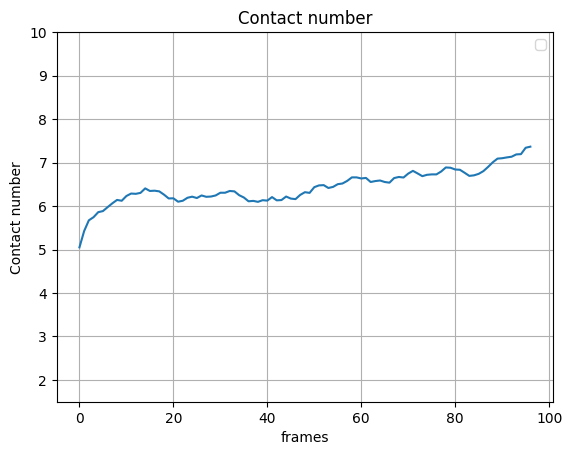

/tmp/ipykernel_4148/1616476794.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


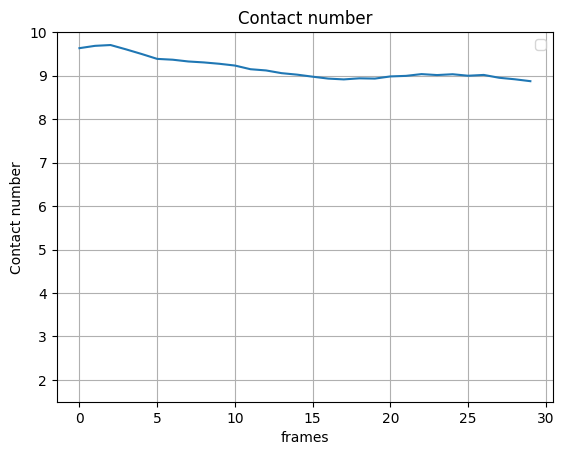

In [17]:
window_size = 5
contact_number = np.convolve(contact_number, np.ones(window_size)/window_size, mode="valid")
comp_contact_number = np.convolve(comp_contact_number, np.ones(window_size)/window_size, mode="valid")

plt.plot(contact_number)
plt.xlabel("frames")
plt.ylabel("Contact number")
plt.title("Contact number")
plt.ylim((1.5,10))

plt.grid()
plt.legend()
plt.show()

plt.plot(comp_contact_number)
plt.xlabel("frames")
plt.ylabel("Contact number")
plt.title("Contact number")
plt.ylim((1.5,10))

plt.grid()
plt.legend()
plt.show()

# Calculate Nematic tensor

In [18]:
nematic = freud.order.Nematic()

In [19]:
def calc_nematic(universe):

    S_values = np.zeros((np.shape(universe)[0]))
    directors = np.zeros((np.shape(universe)[0],3))

    for i,frame in enumerate(universe):
        orientations = np.zeros((np.shape(universe)[1],3))
        for j,mol in enumerate(frame):

            head = mol[0]
            tail = (mol[7] + mol[11])/2

            u = (tail - head)/np.linalg.norm(tail - head)

            orientations[j] = u 

        nematic.compute(orientations)

        S_values[i] = nematic.order
        directors[i] = nematic.director
    
    return S_values, directors

In [20]:
S_values, directors = calc_nematic(all_frames_mol_positions)

In [21]:
comp_S_values, _ = calc_nematic(comp_all_frames_mol_positions)

/tmp/ipykernel_4148/3895674402.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


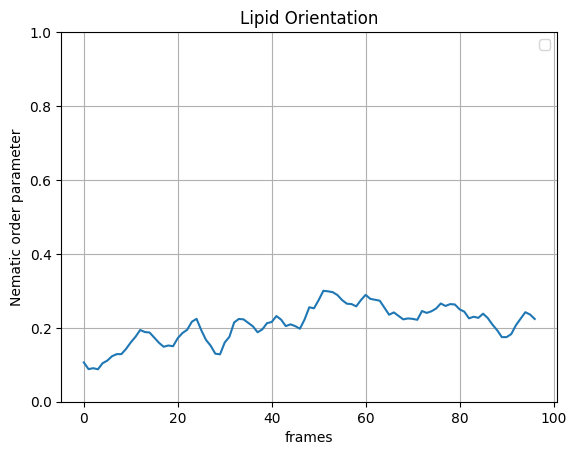

/tmp/ipykernel_4148/3895674402.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


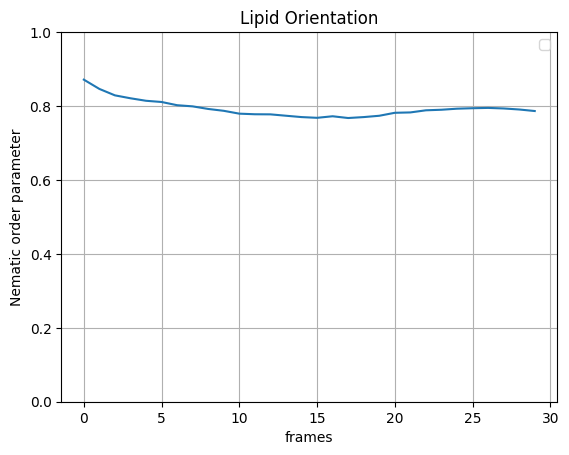

In [22]:
S_values_smooth = np.convolve(S_values, np.ones(window_size)/window_size, mode="valid")

plt.plot(S_values_smooth)
plt.ylim((0,1))
plt.xlabel("frames")
plt.ylabel("Nematic order parameter")
plt.title("Lipid Orientation")

plt.grid()
plt.legend()
plt.show()

comp_S_values = np.convolve(comp_S_values, np.ones(window_size)/window_size, mode="valid")

plt.plot(comp_S_values)
plt.ylim((0,1))
plt.xlabel("frames")
plt.ylabel("Nematic order parameter")
plt.title("Lipid Orientation")

plt.grid()
plt.legend()
plt.show()

# Bilayer structure

In [23]:
best_frame = np.argmax(S_values)
print(directors[best_frame])

[ 0.99637663 -0.03887349  0.07564676]


In [24]:
def calc_density_profile(universe, directors, frame_id, box, n_bins=30):

    frame = universe[frame_id]
    director = directors[frame_id]
    box_dims = box[frame_id]


    all_positions = []
    all_types = []

    for mol in frame:
        for atom_id, position in enumerate(mol):
            pos_wrapped = position - box_dims * np.round(position / box_dims)
            all_positions.append(position)

            if atom_id == 0:
                bead_type = "head"
            # elif atom_id <= 3:
            #     bead_type = "link"
            elif atom_id == 6 or atom_id == 7 or atom_id == 10 or atom_id == 11:
                bead_type = "tail"
        
            all_types.append(bead_type)

    all_positions = np.array(all_positions)
    all_types = np.array(all_types)

    projections = all_positions @ director

    projections = projections - np.mean(projections)


    mask_head = np.array([t == "head" for t in all_types])
    mask_link = np.array([t == "link" for t in all_types])
    mask_tail = np.array([t == "tail" for t in all_types])

    proj_min, proj_max = np.min(projections), np.max(projections)

    bins = np.linspace(proj_min, proj_max, n_bins+1)
    bin_centers = (bins[:-1] + bins[1:])/2
    bin_width = bins[1] - bins[0]

    hist_heads, _ = np.histogram(projections[mask_head], bins=bins)
    hist_links, _ = np.histogram(projections[mask_link], bins=bins)
    hist_tails, _ = np.histogram(projections[mask_tail], bins=bins)

    area = box_dims[0]*box_dims[1]

    bin_vol = area*bin_width

    n_heads = mask_head.sum()
    n_links = mask_link.sum()
    n_tails = mask_tail.sum()

    hist_heads = hist_heads / bin_vol
    hist_links = hist_links / bin_vol
    hist_tails = hist_tails / bin_vol

    # hist_heads = hist_heads / (bin_width*n_heads)
    # hist_links = hist_links / (bin_width*n_links)
    # hist_tails = hist_tails / (bin_width*n_tails)

    # hist_heads = hist_heads / hist_heads.max()
    # hist_links = hist_links / hist_links.max()
    # hist_tails = hist_tails / hist_tails.max()



    return hist_heads, hist_links, hist_tails, bin_centers



In [25]:
hist_heads, hist_links, hist_tails, bin_centers = calc_density_profile(all_frames_mol_positions, directors, best_frame, all_frames_box)

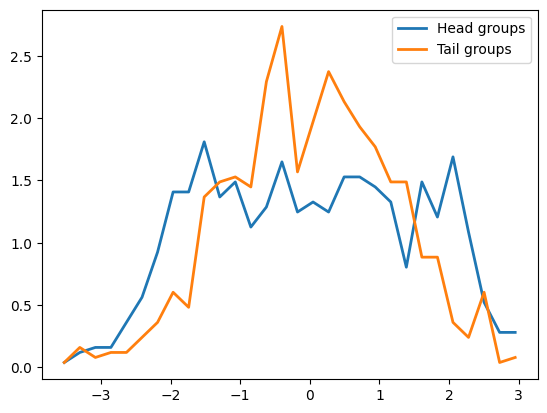

In [26]:
plt.plot(bin_centers, hist_heads, label='Head groups', linewidth=2)
# plt.plot(bin_centers, hist_links, label='Link groups', linewidth=2)
plt.plot(bin_centers, hist_tails, label='Tail groups', linewidth=2)

plt.legend()

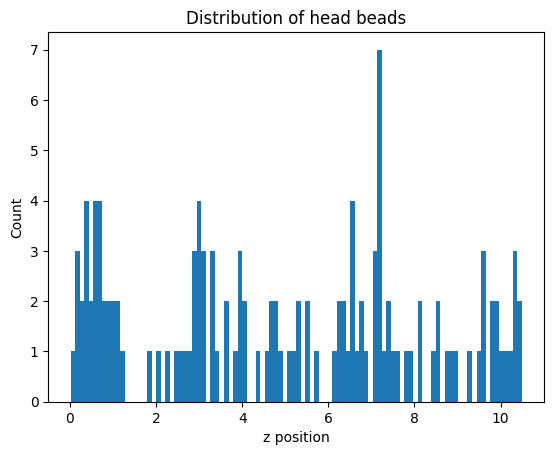

In [27]:
# Prüfe die Verteilung der Molekül-Positionen (z.B. Heads)
frame = all_frames_mol_positions[-1]
head_positions = np.array([mol[0] for mol in frame])  # Alle Kopf-Atome

# Plotte z-Koordinaten
plt.hist(head_positions[:, 2], bins=100)  # Angenommen director ≈ [0,0,1]
plt.xlabel('z position')
plt.ylabel('Count')
plt.title('Distribution of head beads')
plt.show()